# Performance of LSH for coreferences

In [1]:
from load_coreferences import load_coreferences, load_pairs
import lsh 
import copy
import numpy as np
import time 
import matplotlib.pyplot as plt

import cProfile

scaling_factor = 5 # multiply size the original data set by this factor

In [2]:
all_pairs = load_pairs()
raw_mentions = load_coreferences()
mentions = {i: m for i, m in enumerate(raw_mentions)}


#### Effectiveness

In [3]:
def evaluate_coref_predictions(pairs_gold, candidates, _return = False):
    "Precision and recall for LSH coref pair search"
    missed = 0 
    correct = 0 
    wrong = 0

    for mention, true_reference in pairs_gold.items():
        current_candidates = candidates[mention]

        if true_reference not in current_candidates:
            missed += 1
        for candidate in current_candidates:
            if candidate == true_reference:
                correct += 1
            elif candidate != true_reference:
                wrong += 1


    precision = correct / (correct + wrong)
    recall = correct / (correct + missed)

    ndig = 3
    if not _return:
        print(f"Precision: {round(precision, ndig)}") # note: lower precision means larger comparison set for coref classification.
        print(f"Recall: {round(recall, ndig)}") 
    else:
        return (precision, recall)

In [4]:
pairs_gold = {}
for pair_doc in all_pairs.values():
    for p in pair_doc:
        pairs_gold[p[1]] = p[0] # key = mention, value = true coreference



Make signature with a while loop 

In [45]:
mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=4, signature_size=50, band_length=2)

mylsh.cluster()
mylsh.summarise()
candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]]  for idx, mention in mentions.items()}

evaluate_coref_predictions(pairs_gold, candidates)


took 0.10193419456481934 seconds for 174 mentions
average, min, max cluster size: 1.14, 0, 4
Precision: 0.889
Recall: 0.92


Make signature with vectorized approach

In [46]:
mylsh.cluster(numpy_signature=True)
mylsh.summarise()
candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]]  for idx, mention in mentions.items()}

evaluate_coref_predictions(pairs_gold, candidates)

took 0.08054494857788086 seconds for 174 mentions
average, min, max cluster size: 1.07, 0, 3
Precision: 0.872
Recall: 0.862


Properties    
- longer signature $\rightarrow$ higher recall, lower precision
- larger shingle $\rightarrow$ lower recall, higher precision
- longer band $\rightarrow$ lower recall, higher precision


In [40]:

max_signature_size = 300
min_signature_size = 20
# band_lengths = [2, 3, 4] # varying band lengths gives not strictly increasing ROC curve
band_lengths = [2]
shingle_sizes = [2,3,4]

measure_dict = {}

for shingle_size in shingle_sizes:
    l = band_lengths[0]
    measurements = []
    start_size = min_signature_size - (min_signature_size % l) + l # start at next multiple of l
    for s in range(start_size, max_signature_size, l):
        mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=shingle_size, signature_size=s, band_length=l)

        mylsh.cluster()
        candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]]  for idx, mention in mentions.items()}

        m = evaluate_coref_predictions(pairs_gold, candidates, _return=True)
        out = m + (s,)
        measurements.append(out)
    measure_dict[shingle_size] = measurements


In [41]:
md = {k: [
    [1 - i[0] for i in measures], # fpr
    [i[1] for i in measures], # recall,
    [i[2] for i in measures] # signature size
] for k, measures in measure_dict.items()}


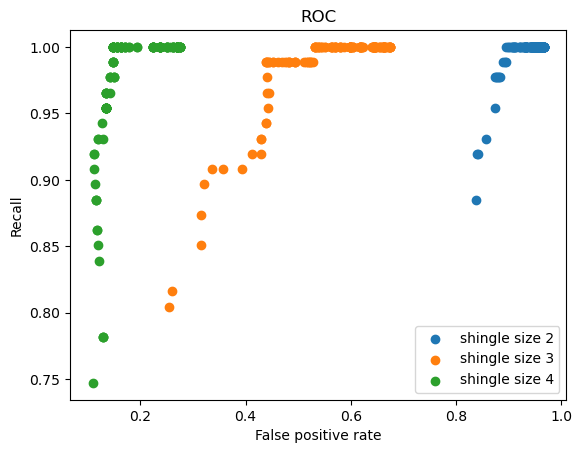

In [42]:
fig, ax = plt.subplots()
for k, v in md.items():
    lbl = f"shingle size {k}"
    ax.scatter(x=v[0], y=v[1], label=lbl)

ax.set_xlabel("False positive rate")
ax.set_ylabel("Recall")
ax.set_title("ROC")
ax.legend()

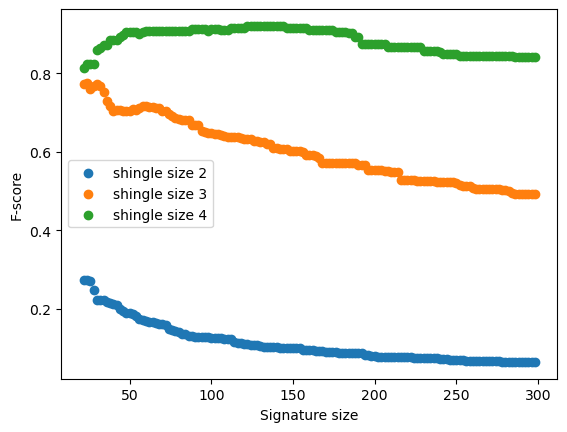

In [48]:
fig, ax = plt.subplots()
for k, v in md.items():
    precision = np.array([1-i for i in v[0]])
    recall = np.array([i for i in v[1]])
    fscore = 2 * precision * recall / (precision + recall)
    lbl = f"shingle size {k}"
    ax.scatter(y=fscore, x=v[2], label=lbl)

ax.set_ylabel("F-score")
ax.set_xlabel("Signature size")
ax.legend()

Notes 
- trade off: get the same recall for smaller false positive rate with larger shingle size, but need a larger signature and thus more time 
    - improve the calculation of the signature?
    - another benefit however is that with a smaller false positive rate, the `with_coref` call in REL will be faster (smaller comparison sets)
    - also important: higher false positive rate means more comparisons also for those mentions that are *not* coreferences (and are not in the present dataset).
    - check again the time complexity of this -- signature length of 300 may not be feasible/lead to long computing time when data set is a few thousands of mentions
- add color shading for shingle size? --
- the can look like they have a negative slope (particularly for shingle size 4). Not sure why. Also happened when I varied the band lengths. does it have to do with the ordering of the input to the plot? 

#### Profiling

What is going on with the numpy signature?

In [8]:
mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=4, signature_size=200, band_length=2)
mylsh._build_vocab()
mylsh.encode_binary(to_numpy=True)


%timeit mylsh.make_signature
%timeit mylsh.make_signature_np

35.2 ns ± 1.54 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
34 ns ± 1.2 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [9]:

cProfile.run("mylsh.make_signature_np()")
# cProfile.run("mylsh.make_signature()")


         78 function calls in 0.275 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(concatenate)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(copyto)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(ndim)
        2    0.000    0.000    0.025    0.013 <__array_function__ internals>:177(tile)
        1    0.000    0.000    0.275    0.275 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _ufunc_config.py:131(geterr)
        2    0.000    0.000    0.000    0.000 _ufunc_config.py:32(seterr)
        1    0.000    0.000    0.000    0.000 _ufunc_config.py:429(__enter__)
        1    0.000    0.000    0.000    0.000 _ufunc_config.py:434(__exit__)
        1    0.000    0.000    0.000    0.000 abc.py:117(__instancecheck__)
        1    0.000    0.000    0.000    0.000 con

In [10]:

# stack mentions on top of each other 
mentions_scaled = copy.copy(mentions)

idx = len(mentions_scaled)
for i in range(1, scaling_factor):
    for idx_old in mentions.keys():
        m = mentions[idx_old]
        mentions_scaled[idx] = m 
        idx += 1

In [11]:
mylsh = lsh.LSHMinHash_nonp(mentions=mentions_scaled, shingle_size=4, signature_size=300, n_buckets=2)
cProfile.run("mylsh.cluster()")

         10 function calls in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.059    0.059 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 lsh.py:123(_build_vocab)
        1    0.000    0.000    0.000    0.000 lsh.py:125(<listcomp>)
        1    0.000    0.000    0.059    0.059 lsh.py:128(encode_binary)
        1    0.000    0.000    0.059    0.059 lsh.py:129(<listcomp>)
        1    0.000    0.000    0.000    0.000 lsh.py:198(_min_hash)
        1    0.000    0.000    0.059    0.059 lsh.py:246(cluster)
        1    0.000    0.000    0.059    0.059 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method time.time}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




AttributeError: 'LSHMinHash_nonp' object has no attribute 'mentions'

In [12]:
mylsh = lsh.LSHMinHash(mentions=mentions_scaled, shingle_size=4, signature_size=300, band_length=2)

cProfile.run("mylsh.cluster()")

         849488 function calls (825167 primitive calls) in 1.405 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      150    0.000    0.000    0.005    0.000 <__array_function__ internals>:177(argsort)
      151    0.000    0.000    0.041    0.000 <__array_function__ internals>:177(array_split)
      153    0.000    0.000    0.003    0.000 <__array_function__ internals>:177(concatenate)
      150    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(copyto)
      300    0.000    0.000    0.003    0.000 <__array_function__ internals>:177(cumsum)
      150    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(diff)
      300    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(empty_like)
      300    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(fliplr)
      300    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(ndim)
      150   

#### Time analysis for sorting multidimensional array along one axis

In [ ]:
# keep this for some time analysis
    # mult before sort -- adapt from the now helper function cols_to_int
x = np.array([[0, 3], [2, 2], [2, 2], [0, 3]]) 
x = np.array([[1, 3], [2, 2], [2, 2], [1, 3], [1, 5], [1, 1]]) # this is one test case
A = np.array([[3,4], [3,5], [5,6], [3,4], [6,7]]) # this is another test case

display(A)
display(np.argsort(A, axis=0))
display(A.view('i8,i8').argsort(order=['f1'], axis=0))

display(x)
display(np.argsort(x, axis=0))
display(x.view('i8,i8').argsort(order=['f1'], axis=0))


n = 100_000
A = np.random.choice(np.arange(int(n/100)), size=(n,2))
%timeit np.argsort(A, axis=0)
%timeit A.view('i8,i8').argsort(order=['f1'], axis=0)
%timeit mult_before_sort(A)

Alternatives to take along axis? -- for reshape

In [21]:
a = np.arange(4000).reshape(200,4,5)
n_reps, n_rows, n_cols = a.shape

a = a.reshape(n_reps*n_rows, n_cols)
idx = np.arange(n_reps*n_rows).reshape(n_reps, n_rows).T.reshape(-1,1)

def new_approach(a):
    a = a[idx,:].squeeze().reshape(n_rows, n_reps, n_cols)
    return a

def old_approach(a):
    a = np.take_along_axis(a, idx, axis=0).reshape(n_rows, n_reps, n_cols)
    return a 

In [22]:
assert np.all(new_approach(a) == old_approach(a))

In [23]:
%timeit old_approach(a)
%timeit new_approach(a)

14.7 µs ± 40.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
7.18 µs ± 37.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [25]:
cProfile.run("new_approach(a)")

         6 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 1295725854.py:7(new_approach)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {method 'reshape' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 {method 'squeeze' of 'numpy.ndarray' objects}




for minhash function

In [120]:
rng = np.random.default_rng(1)
x = rng.normal(0,1,100_000).reshape(100,1000)


In [121]:
n_reps = 200
indices = np.arange(x.shape[1])
rng = np.random.default_rng(3)

# expand by n_reps 
indices_mult = np.tile(indices, (n_reps, 1)) # reorder the columns n_reps times 
x_mult = np.tile(x, (n_reps, 1)).reshape((n_reps,) + x.shape) # new shape: (n_resp, x.shape[0], x.shape[1
permuted_indices = rng.permuted(indices_mult, axis=1)


In [122]:

def old_approach(a, permuted_indices):
    out = np.take_along_axis(a, permuted_indices[:, np.newaxis, :], 2)
    return out 

def new_approach(a, permuted_indices):
    I = np.arange(a.shape[0])[:, np.newaxis]
    out = a[I, :, permuted_indices].swapaxes(1,2)
    return out 

assert np.all(new_approach(x_mult, permuted_indices) == old_approach(x_mult, permuted_indices))


In [123]:
%timeit -n 100 old_approach(x_mult, permuted_indices)
%timeit -n 100 new_approach(x_mult, permuted_indices)

99.1 ms ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
47.5 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
